Assuming diagonal precision matrix for gaussian prior w/ scalar = 10
Assuming prior mean = [-2, -4, 1, 0]
Assuming diagonal precision matrix for gaussian likelihood w/ scalar = 0.5
Generating 4-D Gaussian Samples
y = Ax: Transformation Matrix A is 
[[ 2.1  1.4  1.1 -1. ]
 [-1.3 -1.1  1.   2.3]
 [ 2.  -1.   1.   1. ]
 [-2.  -1.   1.   2. ]]


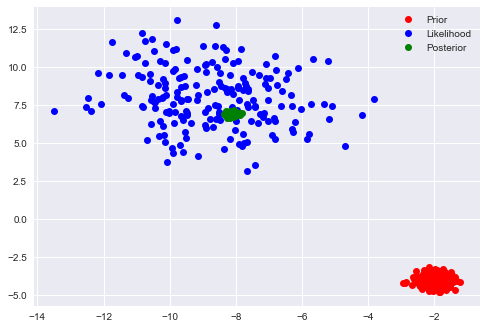

True Posterior Mean: [-8.13703319  6.91941796  0.96449359  8.19480495]
Using Markov Control Variates
Using Robbins Monroe Learning Rates: Tau = 10, Kappa = 0.99
Iteration 0: [ 0.89487603  0.21629316 -2.64154533 -1.27882689] - diff/true_diff: 10 / 10
Iteration 10: [-6.72713228  5.53474756  0.34882254  6.83284246] - diff/true_diff: 0.6682187883827079 / 4.7722048483537
Iteration 20: [-7.70999619  6.79804794  0.6477203   7.99798704] - diff/true_diff: 0.22668255043849828 / 1.0619982151196412
Iteration 30: [-8.14056593  7.2726047   0.76090471  8.3940025 ] - diff/true_diff: 0.09249926765342853 / 0.759505908060513
Iteration 40: [-8.32991371  7.47968416  0.82631393  8.55906641] - diff/true_diff: 0.06667710570746077 / 1.2555878382058743
Iteration 50: [-8.45714741  7.62307362  0.84357018  8.69094529] - diff/true_diff: 0.021835882016891794 / 1.6408336316499261
Iteration 60: [-8.5281349   7.7069622   0.87861819  8.76006329] - diff/true_diff: 0.016342239572021744 / 1.8297796847208947
Iteration 70: [

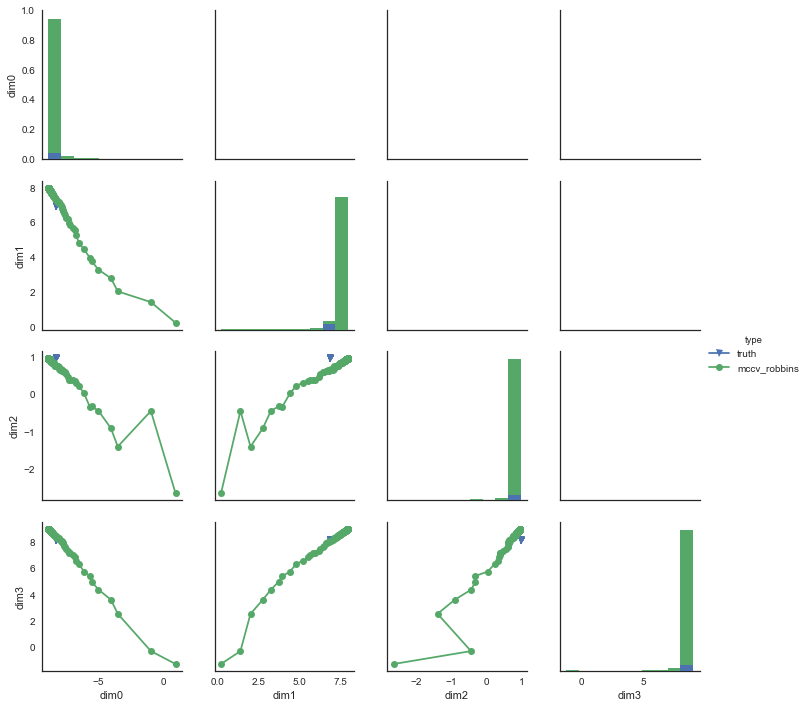

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import inv
from scipy.stats import multivariate_normal as mvn

# Gaussian prior parameters
K = 4
precision_scalar_prior = 10
prior_cov = np.identity(K)
prior_pre = prior_cov * precision_scalar_prior
prior_mu = [-2, -4, 1, 0]

print "Assuming diagonal precision matrix for gaussian prior w/ scalar = " + str(precision_scalar_prior)
print "Assuming prior mean = " + str(prior_mu)

precision_scalar = 0.5
likelihood_pre = np.identity(K) * precision_scalar # a diagonal precision matrix
likelihood_cov = inv(likelihood_pre)

print "Assuming diagonal precision matrix for gaussian likelihood w/ scalar = " + str(precision_scalar)


def generate_gaussian_4d():
    '''
    Calculates and generates samples from the posterior over the mean of a 4-D Gaussian for BBVI testing
    :return:
    '''
    fig1, ax1 = plt.subplots(nrows=1,ncols=1)
    num_samples = 200

    x = np.random.multivariate_normal(prior_mu, inv(prior_pre), num_samples)

    # plot samples from the prior
    ax1.plot( x[:,0], x[:,1], 'ro' )

    # specify likelihood
    # some arbitrary transformation matrix a --> A (block diagonal matrix) y = Ax
    A = np.array([[2.1, 1.4, 1.1, -1], [-1.3, -1.1, 1, 2.3], [2, -1, 1, 1], [-2, -1, 1, 2]])

    print "y = Ax: Transformation Matrix A is "
    print str(A)
    # get likelihood means and precision matrix
    y = np.zeros((num_samples,4))
    for ii in xrange(num_samples):
        y[ii,:] = np.random.multivariate_normal(np.dot(A,x[ii,:]), likelihood_cov)

    # plot for sanity
    ax1.plot( y[:,0], y[:,1], 'bo' )

    # calculate posterior - LOOK AT WIKIPEDIA if you need confirmation
    posterior_cov = inv(prior_pre + (num_samples * likelihood_pre))
    yhat = np.mean(y, axis=0)
    posterior_mu = posterior_cov.dot(prior_pre.dot(prior_mu) + num_samples*likelihood_pre.dot(yhat))
    z = np.random.multivariate_normal(posterior_mu, posterior_cov, num_samples)
    ax1.plot( z[:,0], z[:,1], 'go' )
    plt.legend(['Prior','Likelihood','Posterior'])
    plt.savefig('bbvi_gaussian_samples.png', bbox_inches="tight")
    plt.show()

    print "True Posterior Mean: " + str(posterior_mu)
    return posterior_mu, posterior_cov, y

def qgrad(z, lam, precision):
    '''
    The gradient of the variational distribution. Modify this when changing the variational distribution you wish to
    update with.
    :return:
    '''
    qgrad = precision.dot((z - lam))
    return qgrad

def log_joint(y, z, lam, prior_cov, likelihood_cov):
    '''
    The log joint distribution of the model.
    :return:
    '''
    plog_prior = mvn.logpdf(z, lam.T, prior_cov)
    plog_likelihood = 0
    for ii in xrange(len(y)):
        plog_likelihood += mvn.logpdf(y[ii,:], z.T, likelihood_cov)
    plog_joint = plog_prior + plog_likelihood

    return plog_joint, plog_prior, plog_likelihood


def bbvi_mccv_gaussian(lam=None, lam_true=None, adagrad=True, mccv=True):
    '''
    Runs BBVI for the Gaussian. Has switches for AdaGrad and MCCV.
    :return:
    '''
    lam_old = lam.copy()
    # Set the difference to a large fixed value
    max_iter = 500
    lam_time = np.zeros((max_iter, K))
    lam_diff = 10
    true_diff = 10
    t = 0
    S = 25 # number of samples

    if mccv: print "Using Markov Control Variates" # variance reduction


#     if adagrad:
#         eta = 5
#         print "Using ADAGrad Learning Rates: Eta = " + str(eta)
#         gt = np.zeros(K)
#     else:
    kappa = 0.99
    tau = 10
    print "Using Robbins Monroe Learning Rates: Tau = " + str(tau) + ", Kappa = " + str(kappa)

    while (t < max_iter):
        lam_time[t,:] = lam
        if (t%10==0): print "Iteration " + str(t) + ": " + str(lam) + " - diff/true_diff: " + str(lam_diff) + " / " + str(true_diff)

        # calculate our robbins-monroe learning rate
        z = np.random.multivariate_normal(lam, np.eye(K)*2, S)
        fs = np.zeros((S,K))
        hs = np.zeros((S,K))

        for ss in xrange(S):
            joint, plog_prior, plog_likelihood = log_joint(y, z[ss,:].T, lam, prior_cov, likelihood_cov)
            entropy = mvn.logpdf(z[ss,:].T, lam.T, posterior_cov)
            qg = qgrad(z[ss,:].T, lam.T, posterior_cov)
            fs[ss,:] = qg * (joint - entropy)
            hs[ss,:] = qg

        if mccv:
            aa_cov = 0
            aa_var = 0
            for kk in xrange(K):
                cov_term = np.cov(fs[:,kk], hs[:,kk], bias=1) # covariance matrix
                aa_cov += cov_term[0,1]
                aa_var += cov_term[1,1]
            aa_final = aa_cov / aa_var
            elbo_final = fs - (aa_final * hs)
            elbo_final = np.mean(elbo_final, axis=0)
#         else:
#             elbo_final = np.mean(fs, axis=0)

#         if adagrad:
#             gt += np.power(elbo_final,2)
#             rhos = eta / np.power(gt, 0.5)
#         else:
        rhos = np.power((tau + t), -kappa)
        lam = lam + rhos * elbo_final
        lam_diff = np.sum(np.abs(lam - lam_old))
        true_diff = np.sum(np.abs(lam - lam_true))
        lam_old = lam.copy()
        t += 1
    return lam, lam_time


if __name__ == "__main__":
    # generate gaussian 4d data
    print "Generating 4-D Gaussian Samples"
    posterior_mu, posterior_cov, y = generate_gaussian_4d()

    # initialize our variational parameter for mu randomly
    lam_init = np.random.randn(K)
    df = pd.DataFrame(columns=['dim0','dim1','dim2','dim3','type'])

#     # Generate samples with Robbins Monroe + no MCCV
#     lam, lam_time = bbvi_mccv_gaussian(lam=lam_init, lam_true=posterior_mu, adagrad=False, mccv=False)
#     dft = pd.DataFrame({'dim0':lam_time[:,0], 'dim1':lam_time[:,1], 'dim2':lam_time[:,2], \
#                     'dim3':lam_time[:,3], 'type':['default_robbins'] * len(lam_time)})
#     df = df.append(dft, ignore_index=True)

#     # Generate samples with Adagrad + No MCCV
#     lam, lam_time = bbvi_mccv_gaussian(lam=lam_init, lam_true=posterior_mu, adagrad=True, mccv=False)
#     dft = pd.DataFrame({'dim0':lam_time[:,0], 'dim1':lam_time[:,1], 'dim2':lam_time[:,2], \
#                     'dim3':lam_time[:,3], 'type':['default_adagrad'] * len(lam_time)})
#     df = df.append(dft, ignore_index=True)

    # Generate samples with Robbins Monroe + MCCV
    lam, lam_time = bbvi_mccv_gaussian(lam=lam_init, lam_true=posterior_mu, adagrad=False, mccv=True)
    dft = pd.DataFrame({'dim0':lam_time[:,0], 'dim1':lam_time[:,1], 'dim2':lam_time[:,2], \
                    'dim3':lam_time[:,3], 'type':['mccv_robbins'] * len(lam_time)})
    df = df.append(dft, ignore_index=True)

#     # Generate samples with Adagrad + MCCV
#     lam, lam_time = bbvi_mccv_gaussian(lam=lam_init, lam_true=posterior_mu, adagrad=True, mccv=True)
#     dft = pd.DataFrame({'dim0':lam_time[:,0], 'dim1':lam_time[:,1], 'dim2':lam_time[:,2], \
#                     'dim3':lam_time[:,3], 'type':['mccv_adagrad'] * len(lam_time)})
#     df = df.append(dft, ignore_index=True)

    # Add True Posterior Mean into the dataframe for plotting
    viz_scale = 20
    dft = pd.DataFrame({'dim0':[posterior_mu[0]]*viz_scale, 'dim1':[posterior_mu[1]]*viz_scale, 'dim2':[posterior_mu[2]]*viz_scale, \
                    'dim3':[posterior_mu[3]]*viz_scale, 'type':['truth'] * viz_scale})
    df = df.append(dft, ignore_index=True)

    # Create multi-faceted plot
    sns.set(style="white")
    g = sns.PairGrid(df, hue='type', hue_kws={'marker':["v", "o"]}, \
                     hue_order=['truth','mccv_robbins'], \
                     palette=sns.color_palette())

    g.map_lower(plt.plot)
    g.map_diag(plt.hist)
    g.add_legend()
    g.savefig('bbvi_gaussian.png', bbox_inches="tight")
    plt.show()
